In [1]:
import pints
import pints.toy as toy
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

Minimising error measure
Using Covariance Matrix Adaptation Evolution Strategy (CMA-ES)
Running in sequential mode.
Population size: 7
Iter. Eval. Best      Current   Time    
0     7      686776.8  686776.8   0:00.1
1     14     264585.7  264585.7   0:00.2
2     21     151825    151825     0:00.2
3     28     93276.12  93276.12   0:00.3
20    147    3347.751  5418.488   0:01.2
40    287    774.0448  905.5483   0:02.3
60    427    299.21    299.3511   0:03.5
80    567    249.7781  249.7781   0:04.7
100   707    249.5871  249.5871   0:05.9
120   847    249.5871  249.5871   0:07.1
140   987    249.5871  249.5871   0:08.3
160   1127   249.5871  249.5871   0:09.4
180   1267   249.5871  249.5871   0:10.6
200   1407   249.5871  249.5871   0:11.8
220   1547   249.5871  249.5871   0:13.0
240   1687   249.5871  249.5871   0:14.2
260   1827   249.5871  249.5871   0:15.3
280   1967   249.5871  249.5871   0:16.5
300   2107   249.5871  249.5871   0:17.7
320   2247   249.5871  249.5871   0:19.0
340 

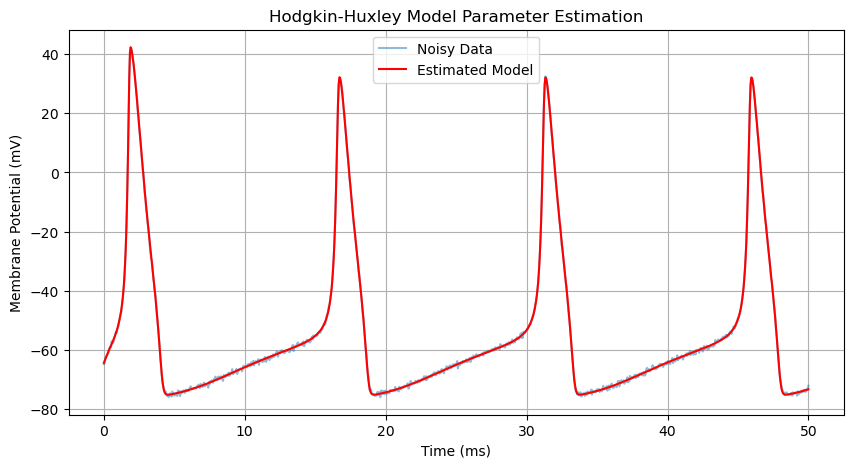

In [2]:
class HodgkinHuxley(pints.ForwardModel):
    """
    Hodgkin-Huxley neuron model as a PINTS forward model.
    """
    def __init__(self):
        super(HodgkinHuxley, self).__init__()

        # Constants
        self.C_m = 1.0    # Membrane capacitance, in uF/cm^2
        self.g_Na = 120.0  # Maximum conductances, in mS/cm^2
        self.g_K = 36.0
        self.g_L = 0.3
        self.E_Na = 50.0   # Reversal potentials, in mV
        self.E_K = -77.0
        self.E_L = -54.387

    def n_inf(self, V):
        return 1.0 / (1.0 + np.exp(-(V + 55.0) / 10.0))

    def m_inf(self, V):
        return 1.0 / (1.0 + np.exp(-(V + 40.0) / 10.0))

    def h_inf(self, V):
        return 1.0 / (1.0 + np.exp((V + 65.0) / 6.0))

    def simulate(self, parameters, times):
        """
        Simulates the Hodgkin-Huxley model over time.
        """
        I_ext, g_Na, g_K = parameters  # External current and conductances

        # Initialize variables
        V = -65.0  # Membrane potential
        n = self.n_inf(V)
        m = self.m_inf(V)
        h = self.h_inf(V)

        dt = times[1] - times[0]
        V_trace = []

        for t in times:
            # Gating variable derivatives
            alpha_n = (0.01 * (V + 55)) / (1 - np.exp(-(V + 55) / 10))
            beta_n = 0.125 * np.exp(-(V + 65) / 80)
            dn = alpha_n * (1 - n) - beta_n * n

            alpha_m = (0.1 * (V + 40)) / (1 - np.exp(-(V + 40) / 10))
            beta_m = 4.0 * np.exp(-(V + 65) / 18)
            dm = alpha_m * (1 - m) - beta_m * m

            alpha_h = 0.07 * np.exp(-(V + 65) / 20)
            beta_h = 1 / (1 + np.exp(-(V + 35) / 10))
            dh = alpha_h * (1 - h) - beta_h * h

            # Ionic currents
            I_Na = g_Na * (m ** 3) * h * (V - self.E_Na)
            I_K = g_K * (n ** 4) * (V - self.E_K)
            I_L = self.g_L * (V - self.E_L)

            # Membrane potential derivative
            dV = (I_ext - I_Na - I_K - I_L) / self.C_m

            # Update variables
            V += dV * dt
            n += dn * dt
            m += dm * dt
            h += dh * dt

            V_trace.append(V)

        return np.array(V_trace)

    def n_parameters(self):
        return 3  # External current, g_Na, g_K as parameters

    def generate_synthetic_data(self, true_params, times, noise_std=0.5):
        """Generate synthetic voltage data with noise."""
        voltage = self.simulate(true_params, times)
        noisy_voltage = voltage + np.random.normal(0, noise_std, voltage.shape)
        return noisy_voltage

    def optimize_parameters(self, times, noisy_data, method=pints.CMAES):
        """Estimate I_ext, g_Na, and g_K using PINTS optimization."""
        problem = pints.SingleOutputProblem(self, times, noisy_data)
        error_measure = pints.SumOfSquaresError(problem)
        optimizer = pints.OptimisationController(error_measure, [10, 100, 30], method=method)
        optimizer.set_max_iterations(1000)
        estimated_params, _ = optimizer.run()
        return estimated_params

if __name__ == "__main__":
    # Instantiate the model
    model = HodgkinHuxley()

    # Time array
    time = np.linspace(0, 50, 1000)  # 0 to 50 ms

    # True parameters: I_ext, g_Na, g_K
    true_params = [10, 120, 36]

    # Generate synthetic data
    noisy_voltage = model.generate_synthetic_data(true_params, time)

    # Optimize parameters
    estimated_params = model.optimize_parameters(time, noisy_voltage)
    print(f"Estimated Parameters: I_ext={estimated_params[0]:.2f}, g_Na={estimated_params[1]:.2f}, g_K={estimated_params[2]:.2f}")

    # Simulate with estimated parameters
    estimated_voltage = model.simulate(estimated_params, time)

    # Plot results
    plt.figure(figsize=(10, 5))
    plt.plot(time, noisy_voltage, label='Noisy Data', alpha=0.5)
    plt.plot(time, estimated_voltage, 'r-', label='Estimated Model')
    plt.title('Hodgkin-Huxley Model Parameter Estimation')
    plt.xlabel('Time (ms)')
    plt.ylabel('Membrane Potential (mV)')
    plt.legend()
    plt.grid()
    plt.show()


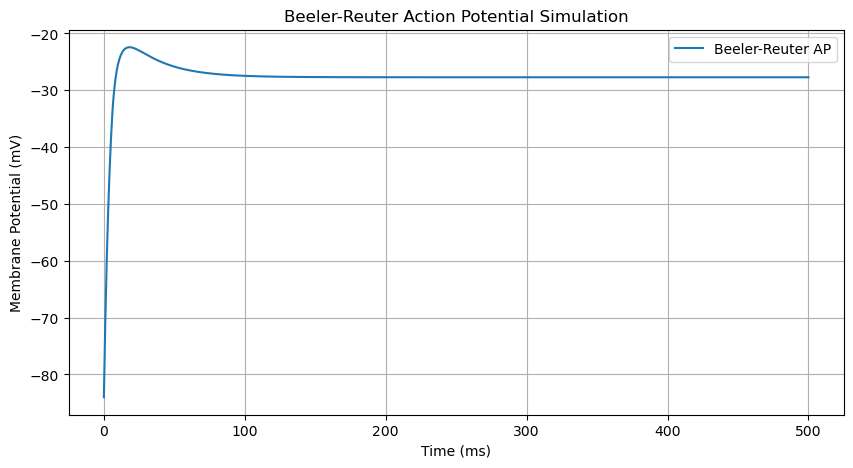

In [3]:
class BeelerReuterModel(pints.ForwardModel):
    """
    Beeler-Reuter 1977 model for cardiac ventricular myocytes.
    Implements dV/dt = - (I_Na + I_Ca + I_K + I_x1 + I_stim)
    """

    def __init__(self):
        super(BeelerReuterModel, self).__init__()

    def n_parameters(self):
        return 1  # Only stimulus current I_stim is treated as a parameter

    def initial_conditions(self):
        """ Initial conditions based on Beeler-Reuter model """
        return [-84.0, 0.01, 0.8, 0.01, 0.1, 1.0]  # [V, m, h, j, d, f]

    def _gating_variables(self, V):
        """ Compute gating variables (steady-state values and time constants) """
        alpha_m = (0.1 * (V + 47)) / (1 - np.exp(-0.1 * (V + 47)))
        beta_m = 4 * np.exp(-0.056 * (V + 72))
        alpha_h = 0.07 * np.exp(-0.05 * (V + 72))
        beta_h = 1 / (1 + np.exp(-0.1 * (V + 42)))
        alpha_j = (0.1 * np.exp(-0.1 * (V + 72))) / (1 + np.exp(-0.1 * (V + 42)))
        beta_j = 0.1 / (1 + np.exp(-0.1 * (V + 42)))

        return alpha_m, beta_m, alpha_h, beta_h, alpha_j, beta_j

    def simulate(self, parameters, times):
        """ Simulate action potential using Beeler-Reuter model """
        I_stim = parameters[0]
        dt = times[1] - times[0]
        num_steps = len(times)
        states = np.zeros((num_steps, 6))  # [V, m, h, j, d, f]
        states[0, :] = self.initial_conditions()

        for i in range(1, num_steps):
            V, m, h, j, d, f = states[i - 1, :]

            # Gating variables
            alpha_m, beta_m, alpha_h, beta_h, alpha_j, beta_j = self._gating_variables(V)
            
            # Ionic currents (simplified)
            I_Na = 4 * (m**3) * h * j * (V - 50)  # Sodium current
            I_Ca = 0.09 * d * f * (V - 120)       # Calcium current
            I_K = 0.282 * (V + 77)                # Potassium current
            I_x1 = 0.001 * (V + 60) / (1 - np.exp(-0.1 * (V + 60)))  # Background current

            # Differential equations
            dVdt = - (I_Na + I_Ca + I_K + I_x1 + I_stim)
            dmdt = alpha_m * (1 - m) - beta_m * m
            dhdt = alpha_h * (1 - h) - beta_h * h
            djdt = alpha_j * (1 - j) - beta_j * j
            dddt = 0.1 * (1 - d) - 0.07 * d  # Simplified calcium activation
            dfdt = 0.02 * (1 - f) - 0.02 * f

            # Euler integration
            states[i, 0] = V + dt * dVdt
            states[i, 1] = m + dt * dmdt
            states[i, 2] = h + dt * dhdt
            states[i, 3] = j + dt * djdt
            states[i, 4] = d + dt * dddt
            states[i, 5] = f + dt * dfdt

        return states[:, 0]  # Return only the voltage trace

# Set up and simulate the Beeler-Reuter model
model = BeelerReuterModel()
times = np.linspace(0, 500, 1000)  # 500ms simulation with 1000 time points
parameters = [-10]  # Stimulus current I_stim

voltage_trace = model.simulate(parameters, times)

# Plot results
plt.figure(figsize=(10, 5))
plt.plot(times, voltage_trace, label="Beeler-Reuter AP")
plt.xlabel("Time (ms)")
plt.ylabel("Membrane Potential (mV)")
plt.title("Beeler-Reuter Action Potential Simulation")
plt.legend()
plt.grid()
plt.show()


## SEIR Model

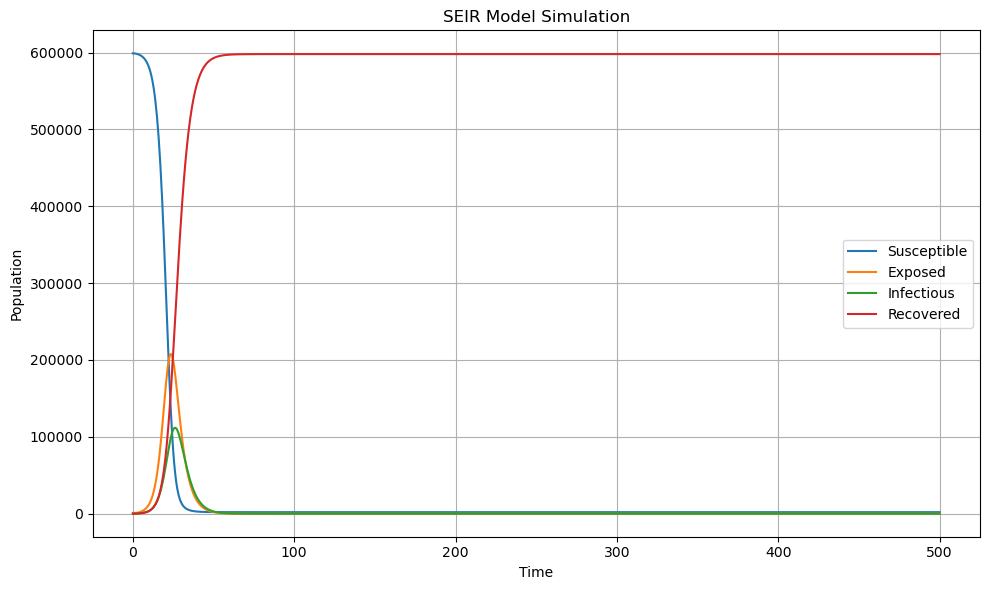

In [4]:
class SimpleSEIRModel(pints.ForwardModel):
    """
    Basic SEIR model with compartments:
    S: Susceptible
    E: Exposed (infected but not yet infectious)
    I: Infectious
    R: Recovered
    Parameters:
        beta: Transmission rate
        kappa: Incubation rate (1/average incubation period)
        gamma: Recovery rate (1/average infectious period)
    """

    def __init__(self):
        super(SimpleSEIRModel, self).__init__()
        self.crude_R_t=0

    def n_parameters(self):
        return 3  # beta, kappa, gamma

    def n_outputs(self):
        return 4  # S, E, I, R

    def simulate(self, initial_conditions, parameters, times):
        beta, kappa, gamma = parameters
        dt = times[1] - times[0]
        num_steps = len(times)

        # Initial conditions: [S, E, I, R]
        S0, E0, I0, R0 = initial_conditions
        states = np.zeros((num_steps, 4))
        states[0] = [S0, E0, I0, R0]

        for i in range(1, num_steps):
            S, E, I, R = states[i - 1]
            N = S + E + I + R

            dS = -beta * S * I / N
            dE = beta * S * I / N - kappa * E
            dI = kappa * E - gamma * I
            dR = gamma * I

            states[i, 0] = S + dt * dS
            states[i, 1] = E + dt * dE
            states[i, 2] = I + dt * dI
            states[i, 3] = R + dt * dR

        self._estimate_crude_R_t(states)

        return states

    def _estimate_crude_R_t(self, states):
        pop_size = np.sum(states[0])
        susceptible = states[:, 0]
        infected = states[:, 2]
        recovered = states[:, 3]

        # Estimate beta and gamma
        dS_dt = np.gradient(susceptible)
        dR_dt = np.gradient(recovered)
        with np.errstate(divide='ignore', invalid='ignore'):
            beta_estimate = - dS_dt * pop_size / (susceptible * infected)
            gamma_estimate = dR_dt / infected
            crude_R_t = beta_estimate * susceptible / (pop_size * gamma_estimate)

        crude_R_t = np.mean(crude_R_t[np.isfinite(crude_R_t)])
        self.crude_R_t=crude_R_t

# Instantiate and simulate the model
model = SimpleSEIRModel()
times = np.linspace(0, 500, 1000)
parameters = [1.8, 1/5, 1/3]
initial_conditions = [599000,1000,0,0]

seir_output = model.simulate(initial_conditions, parameters, times)
S, E, I, R = seir_output.T  # Transpose to unpack each compartment

# Plot results
plt.figure(figsize=(10, 6))
plt.plot(times, S, label="Susceptible")
plt.plot(times, E, label="Exposed")
plt.plot(times, I, label="Infectious")
plt.plot(times, R, label="Recovered")
plt.xlabel("Time")
plt.ylabel("Population")
plt.title("SEIR Model Simulation")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## Roche Model

In [5]:
class RocheModel(SimpleSEIRModel):
    """
    Basic SEIR model with compartments:
    S: Susceptible
    E: Exposed (infected but not yet infectious)
    I: Infectious
    R: Recovered
    Parameters:
        beta: Transmission rate
        kappa: Incubation rate (1/average incubation period)
        gamma: Recovery rate (1/average infectious period)
    """

    def __init__(self, initial_conditions):
        super(RocheModel, self).__init__()
        self.initial_conditions=initial_conditions
    
    def get_n(self, states):

        return np.sum(states)

    def n_parameters(self):
        return 8  # beta, kappa, gamma

    def n_outputs(self):
        return 4  # S, E, I, R

    def simulate(self, parameters, times):
        # Run full SEIR simulation
        states = self._full_simulate(self.initial_conditions, parameters, times)
        return states

    def _full_simulate(self, initial_conditions, parameters, times):
        C, beta_min, beta_max, stringency, stringency50, k, k_s, k_ri = parameters

        dt = times[1] - times[0]
        num_steps = len(times)

        # Initial conditions: [S, E, I, R]
        S0, E0, I0, R0 = initial_conditions
        states = np.zeros((num_steps, 4))
        states[0] = [S0, E0, I0, R0]

        #symptomatic transmission rate βs

        N = S0 + E0 + I0 + R0

        kappa = 1/k

        gamma = 1/(k_s+k_ri)
        
        beta_s= (beta_max - (beta_max-beta_min) * ((stringency**gamma)/(stringency**gamma + stringency50**gamma)))/2*N

        beta=C*(beta_s/(2*N))

        for i in range(1, num_steps):
            S, E, I, R = states[i - 1]
            

            
            dS = -beta * S * I / N
            dE = beta * S * I / N - kappa * E
            dI = kappa * E - gamma * I
            dR = gamma * I

            states[i, 0] = S + dt * dS
            states[i, 1] = E + dt * dE
            states[i, 2] = I + dt * dI
            states[i, 3] = R + dt * dR

        
        self._estimate_crude_R_t(states)

        return states  # Return all compartments
    
def extract_initial_conditions_and_observed(filepath, time_col='time'):
    """
    Extracts SEIR initial conditions and full observed SEIR trajectories from file.

    Parameters
    ----------
    filepath : str
        Path to the simulation CSV file.
    time_col : str
        Name of the time column in the file.

    Returns
    -------
    initial_conditions : list of float
        [S0, E0, I0, R0] values at time = 0
    observed : np.ndarray
        Array of shape (n_timesteps, 4) for [S, E, I, R] over time.
    """
    df_raw = pd.read_csv(filepath, sep=None, engine='python')

    # Group data by time, summing over age groups and cells
    grouped = df_raw.groupby(time_col).agg({
        "InfectionStatus.Susceptible": "sum",
        "InfectionStatus.Exposed": "sum",
        "InfectionStatus.Recovered": "sum",
        "InfectionStatus.InfectASympt": "sum",
        "InfectionStatus.InfectMild": "sum",
        "InfectionStatus.InfectGP": "sum",
        "InfectionStatus.InfectHosp": "sum",
        "InfectionStatus.InfectICU": "sum",
        "InfectionStatus.InfectICURecov": "sum"
    })

    # Construct infected compartment
    grouped["Infected"] = grouped[
        [
            "InfectionStatus.InfectASympt",
            "InfectionStatus.InfectMild",
            "InfectionStatus.InfectGP",
            "InfectionStatus.InfectHosp",
            "InfectionStatus.InfectICU",
            "InfectionStatus.InfectICURecov"
        ]
    ].sum(axis=1)

    # Build SEIR observed matrix
    observed = grouped[[
        "InfectionStatus.Susceptible",
        "InfectionStatus.Exposed",
        "Infected",
        "InfectionStatus.Recovered"
    ]].values

    # Extract initial conditions (first row)
    initial_conditions = observed[0].tolist()

    return initial_conditions, observed


In [6]:

# Load the data (use your existing helper function)
initial_conditions, observed = extract_initial_conditions_and_observed(
    r"epi_data_comparison\simulation_outputs\normal\output_luxembourg.csv"
)


# Instantiate and simulate the model
model = RocheModel(initial_conditions)
times = np.linspace(0, 500, 1000)
parameters = [
    35,      # C: scaling factor (unitless)
    0.135,    # beta_min: minimum daily infection rate
    1.08,     # beta_max: maximum infection rate (symptomatic, no mitigation)
    50,     # stringency index (%)
    60,     # max stringency (%)
    2.59,     # k: time to become infectious after exposure (days)
    10,     # k_s: time from infectiousness to symptom onset (days)
    10,      # k_ri: time to recover for asymptomatic/mild cases (days)
]


seir_output = model._full_simulate(parameters, times)
S, E, I, R = seir_output.T  # Transpose to unpack each compartment

# Plot results
plt.figure(figsize=(10, 6))
plt.plot(times, S, label="Susceptible")
plt.plot(times, E, label="Exposed")
plt.plot(times, I, label="Infectious")
plt.plot(times, R, label="Recovered")
plt.xlabel("Time")
plt.ylabel("Population")
plt.title("SEIR Model Simulation")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

TypeError: _full_simulate() missing 1 required positional argument: 'times'

In [ ]:
def run_pints_fit_multioutput(model, initial_conditions, times, observed, sigma=10.0, boundaries=None):
    """
    Fit Roche SEIR model using Pints CMA-ES and multi-output log-likelihood.

    Parameters
    ----------
    model : pints.ForwardModel (returns 2D array)
        Your SEIR RocheModel.
    initial_conditions : list
        Initial SEIR values [S, E, I, R].
    times : np.array
        Time points.
    observed : np.ndarray
        2D array (timepoints x compartments), e.g. columns for S, E, I, R.
    sigma : float or np.ndarray
        Std dev of Gaussian noise for each compartment. Can be scalar or 1D array.
    boundaries : pints.RectangularBoundaries
        Optional parameter bounds.

    Returns
    -------
    dict with parameter estimates and derived values.
    """
    # Define problem (MultiOutputProblem needs full simulate output)
    problem = pints.MultiOutputProblem(model, times, observed)

    # Define Gaussian noise model
    log_likelihood = pints.GaussianKnownSigmaLogLikelihood(problem, sigma=np.ones(4) * 10)

    lower = [1, 0.01, 0.5, 0, 10, 1, 1, 1]
    upper = [100, 0.5, 2.0, 100, 100, 10, 14, 21]
    log_prior = pints.UniformLogPrior(lower, upper)

    print("log_prior.shape", log_prior.n_parameters())
    print("log_likelihood.shape", log_likelihood.n_parameters())

    # Combine
    log_posterior = pints.LogPosterior(log_likelihood, log_prior)

    # Initial guess
    x0 = [35, 0.1, 1.2, 50, 60, 2.5, 10, 10,]

    # Optimisation
    optimiser = pints.OptimisationController(
        log_posterior, x0, method=pints.CMAES, boundaries=boundaries
    )
    optimiser.set_max_iterations(1000)
    optimiser.set_parallel(False)

    found_params, found_value = optimiser.run()

    # Derive quantities
    C, beta_min, beta_max, stringency, stringency50, k, k_s, k_ri = found_params
    kappa = 1 / k
    gamma = 1 / (k_s + k_ri)
    pop_size = sum(initial_conditions)
    beta_s = (beta_max - (beta_max - beta_min) *
              ((stringency**gamma) / (stringency**gamma + stringency50**gamma))) / (2 * pop_size)
    beta = C * beta_s

    model._full_simulate(initial_conditions, found_params, times)
    R_t = model.crude_R_t

    # Simulate using best-fit parameters
    sim_output = model.simulate(found_params, times)  # shape (n_times, 4)

    # Plot SEIR comparisons
    import matplotlib.pyplot as plt

    labels = ['Susceptible', 'Exposed', 'Infected', 'Recovered']
    fig, axs = plt.subplots(4, 1, figsize=(10, 12), sharex=True)

    for i, ax in enumerate(axs):
        ax.plot(times, observed[:, i], label='Observed', linestyle='--')
        ax.plot(times, sim_output[:, i], label='Simulated', linewidth=2)
        ax.set_ylabel(labels[i])
        ax.legend()
        ax.grid(True)

    axs[-1].set_xlabel("Time")
    fig.suptitle("Observed vs Simulated SEIR", fontsize=16)
    plt.tight_layout()
    plt.show()

    return {
        'optimized_parameters': found_params,
        'log_posterior': found_value,
        'beta': beta,
        'gamma': gamma,
        'kappa': kappa,
        'R_estimate': R_t
    }


In [ ]:
# Prepare data
initial_conditions, observed = extract_initial_conditions_and_observed(r"epi_data_comparison\simulation_outputs\normal\output_luxembourg.csv")



In [ ]:
times = np.linspace(0, 100, 201)
print(times.shape)


(201,)


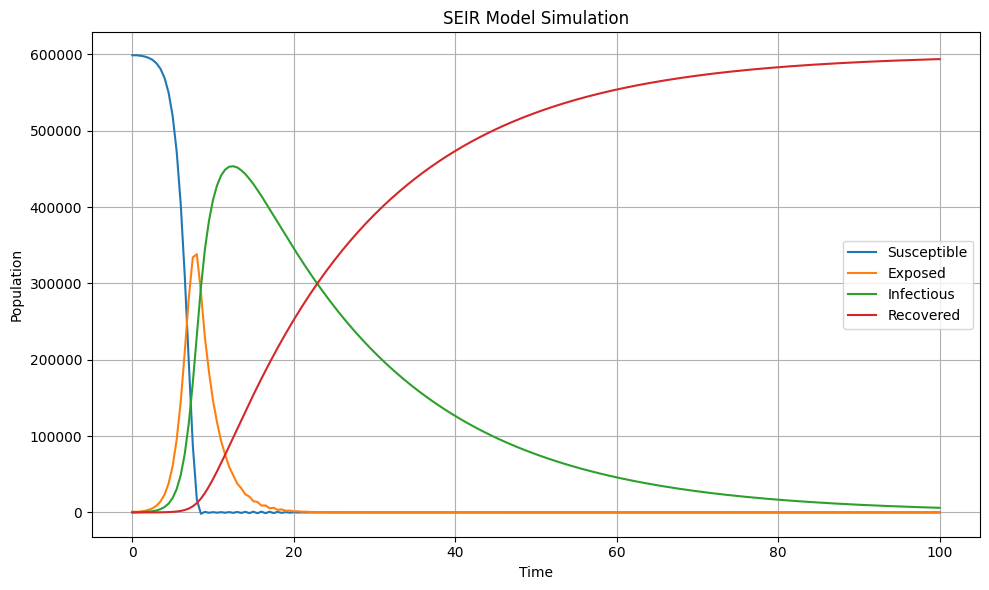

{'optimized_parameters': array([ 2.91543357,  0.09704945,  0.50105973, 38.66006426, 62.21586158,
        7.73200522, 14.        , 21.        ]), 'log_posterior': -46202529651.24944, 'beta': 7.298973361760935e-07, 'gamma': 0.028571428571428675, 'kappa': 0.12933255629125617, 'R_estimate': 5.142248964531621}


In [ ]:
# Fit
model = RocheModel( [599000, 1000, 0, 0])
parameters = [35, 0.1, 1.2, 50, 60, 2.5, 10, 10,]
roche_output = model.simulate(parameters, times)
S, E, I, R = roche_output.T  # Transpose to unpack each compartment

# Plot results
plt.figure(figsize=(10, 6))
plt.plot(times, S, label="Susceptible")
plt.plot(times, E, label="Exposed")
plt.plot(times, I, label="Infectious")
plt.plot(times, R, label="Recovered")
plt.xlabel("Time")
plt.ylabel("Population")
plt.title("SEIR Model Simulation")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()